In [62]:
from scipy.io import loadmat
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spl
import scipy as sp
import matplotlib.pyplot as plt
import SolveTriangular

In [63]:
dati = loadmat("test_II.mat")
A = dati["A"]
A = A.astype(float)
b = dati["b"]
b = b.astype(float)

Dimensione: (400,400)
Simmetrica: True
Definita positiva: True
Sparsa: True
Condizionamento: 2.9558167947973546


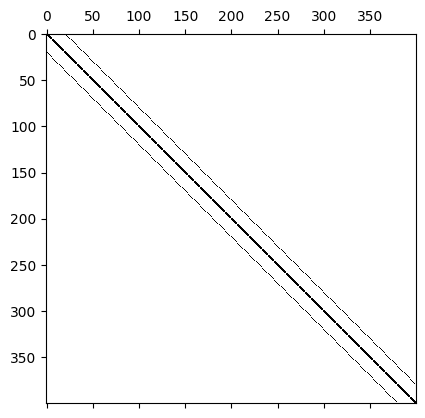

In [64]:
n, m = A.shape
size = n * m
non_zeros = np.count_nonzero(A)

print(f"Dimensione: ({n},{m})")
print("Simmetrica:", np.all(A.T == A))
print("Definita positiva:", np.all(npl.eigvals(A) > 0))
print("Sparsa:", non_zeros / size <= 0.33)
print("Condizionamento:", npl.cond(A))

plt.spy(A)

In [65]:
def steepestdescent(A, b, x0, itmax, tol):

    n, m = A.shape
    if n != m:
        print("Matrice non quadrata")
        return [], []

    # inizializzare le variabili necessarie
    x = x0
    r = A @ x - b
    p = -r
    it = 0

    nb = np.linalg.norm(b)
    errore = np.linalg.norm(r) / nb
    vec_sol = []
    vec_sol.append(x)
    vet_r = []
    vet_r.append(errore)

    # utilizzare il metodo del gradiente per trovare la soluzione
    while it < itmax and errore >= tol:
        it = it + 1
        Ap = A @ p

        alpha = -(r.T @ p) / (p.T @ Ap)
        x = x + alpha * p

        vec_sol.append(x)
        r = r + alpha * Ap
        errore = np.linalg.norm(r) / nb
        vet_r.append(errore)
        p = -r

    return x, vet_r, vec_sol, it

In [66]:
def conjugate_gradient(A, b, x0, itmax, tol):
    n, m = A.shape
    if n != m:
        print("Matrice non quadrata")
        return [], []

    # inizializzare le variabili necessarie
    x = x0
    r = A @ x - b
    p = -r
    it = 0

    nb = np.linalg.norm(b)
    errore = np.linalg.norm(r) / nb
    vec_sol = []
    vec_sol.append(x0)
    vet_r = []
    vet_r.append(errore)

    # utilizzare il metodo del gradiente coniugato per calcolare la soluzione
    while errore >= tol and it < itmax:
        it = it + 1

        Ap = A @ p
        alpha = (r.T @ r) / (p.T @ Ap)
        x = x + alpha * p
        vec_sol.append(x)

        rtr_old = r.T @ r
        r = r + alpha * Ap
        gamma = (r.T @ r) / rtr_old
        p = -r + gamma * p

        errore = np.linalg.norm(r) / nb
        vet_r.append(errore)


    return x, vet_r, vec_sol, it

Iterazione steep: 35
Iterazioni conjugate: 20


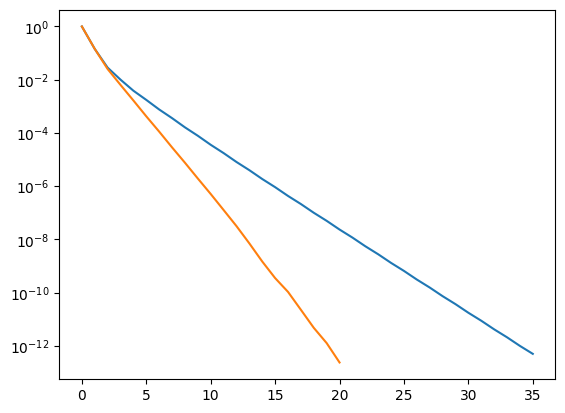

In [67]:
x0 = np.zeros_like(b)
toll = 1e-12
itmax = 400

x_steep, vet_err_steep, vec_sol_steep, it_steep = steepestdescent(A, b, x0, itmax, toll)
x_conj, vet_err_conj, vec_sol_conj, it_conj = conjugate_gradient(A, b, x0, itmax, toll)

print("Iterazione steep:", it_steep)
print("Iterazioni conjugate:", it_conj)

plt.semilogy(range(it_steep + 1), vet_err_steep, range(it_conj+1), vet_err_conj)

> Per via del movimento a zig-zag caraterristico del metodo dello steepest descent in cui la direzione di discesa è scelta unicamente come l'antigradiente il metodo converge in più iterazioni rispetto al metodo del gradiente coniugato in cui la direazione di discesa viene scelta tengono anche conto della direazione coniugata a quelle precedenti in modo che punti verso il centro.
> La velocità di convergenza per il metodo dello steepest descent è data dal rapporto (K(A) - 1) / (K(A) + 1), più l'indice di condizionamento è alto, più la velocità di convergenza è bassa; mentre per il metodo del gradiente coniugato è dato da (sqrt(K(A)) - 1) / (sqrt(K(A) + 1)), in questo caso l'indice di condizionamento è smorzato dalla radice ed avrà quindi un impatto minore sulla velocità di convergenza. Per questo particolare esempio, l'indice di condizionamento è molto basso quindi la velocità di convergenza non differisce di molto.

In [68]:
def eqnorm(A,b):
#Risolve un sistema sovradeterminato con il metodo delle equazioni normali
    G = A.T @ A
    f = A.T @ b

    L = spl.cholesky(G, lower=True)
    U=L.T

    z, flag =  SolveTriangular.Lsolve(L, f)
    x, flag = SolveTriangular.Usolve(U, z)

    return x

In [69]:
x = np.array([0.0004, 0.2507, 0.5008, 2.0007, 8.0013])
y = np.array([0.0007, 0.0162, 0.0288, 0.0309, 0.0310])
xx = np.linspace(np.min(x), np.max(x), 100)

Errore: 0.0004848327762313228


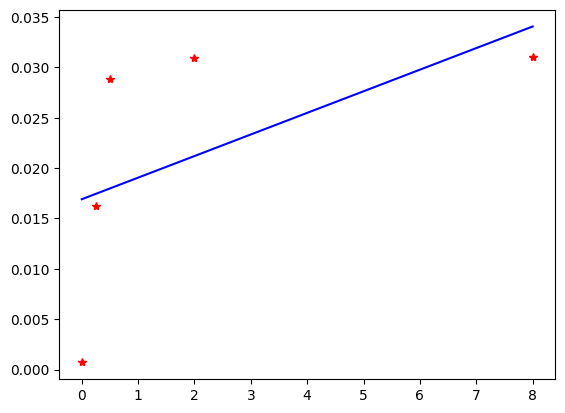

In [83]:
n = 1
B = np.vander(x, n+1, increasing=True)
alpha_lin = eqnorm(B, y)

y_hat = np.polyval(np.flip(alpha_lin), x)
errore = npl.norm(y-y_hat, 2)**2
print("Errore:", errore)

yy = np.polyval(np.flip(alpha_lin), xx)
plt.plot(x, y, 'r*', xx, yy, 'b-')

Errore: 0.00023646355940249857


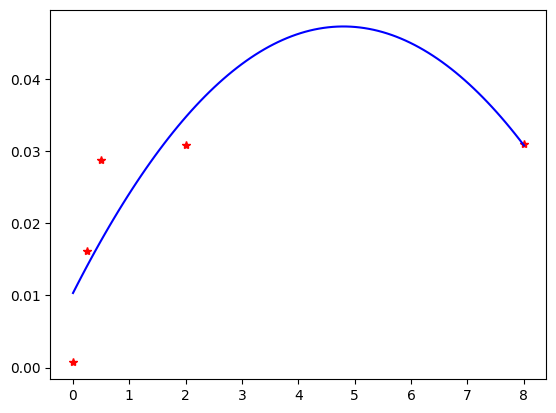

In [84]:
n = 2
B = np.vander(x, n+1, increasing=True)
alpha_quadr = eqnorm(B, y)

y_hat = np.polyval(np.flip(alpha_quadr), x)
errore = npl.norm(y-y_hat, 2)**2
print("Errore:", errore)

yy = np.polyval(np.flip(alpha_quadr), xx)
plt.plot(x, y, 'r*', xx, yy, 'b-')

Errore: 1.2249733128901824e-05


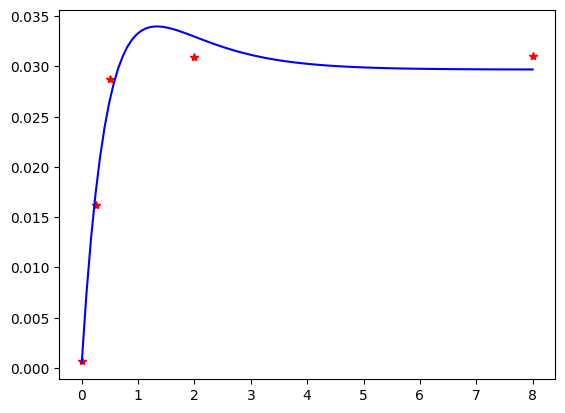

In [85]:
# y = a + b*e^-x + c*e^-2x
B = np.column_stack((np.full_like(x, 1), 1/np.exp(x), 1/np.exp(2*x)))
alpha_exp = eqnorm(B, y)

y_hat = alpha_exp[0]*B[:,0] + alpha_exp[1]*B[:,1] + alpha_exp[2]*B[:,2]
errore = npl.norm(y-y_hat, 2)**2
print("Errore:", errore)

B_val = np.column_stack((np.full_like(xx, 1), 1/np.exp(xx), 1/np.exp(2*xx)))
yy = alpha_exp[0]*B_val[:,0] + alpha_exp[1]*B_val[:,1] + alpha_exp[2]*B_val[:,2]
plt.plot(x, y, 'r*', xx, yy, 'b-')